***Problem Setup***

Define a double pendulum system with parameters $m_1$, $m_2$, $l_1$, $l_2$. Create a functions for a Lagrangian, $\ddot{\theta}\big[\mathcal{L}_{ag}\big]$, $\ddot{\theta}_{true}$, and Euler step methods for both autograd and true accelerations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from torch.func import jacfwd, jacrev, vmap
import time
import torch
from torch import tensor, sum, log, max, cos, sin, pi, clone, sqrt, mean, std
from scipy.constants import g
from dpfuncs import *
#####
# problem setup

m1 = torch.tensor([1],dtype=torch.float64)
l1 = torch.tensor([1],dtype=torch.float64)
m2 = torch.tensor([1],dtype=torch.float64)
l2 = torch.tensor([1],dtype=torch.float64)

n_points = 250


t0_min = -2*pi
t0_max = 2*pi
t1_min = -2*pi
t1_max = 2*pi

tdot_min = -0
tdot_max = 0






***Validation***

Now run Euler's method for both the autograd Lagrangian $\mathcal{L}_{ag}$ and true $\ddot{\theta}$, calculate error, and plot:

100%|██████████| 100/100 [00:00<00:00, 19386.66it/s]


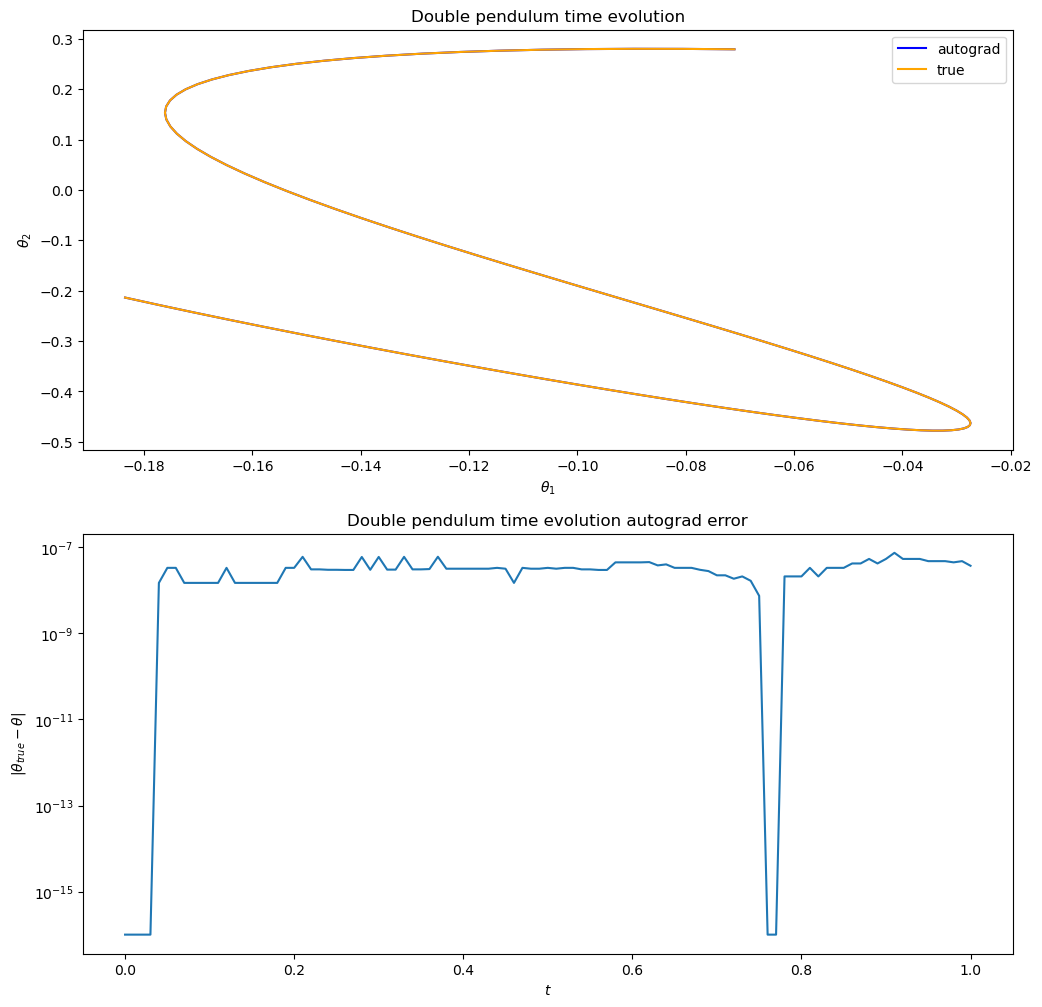

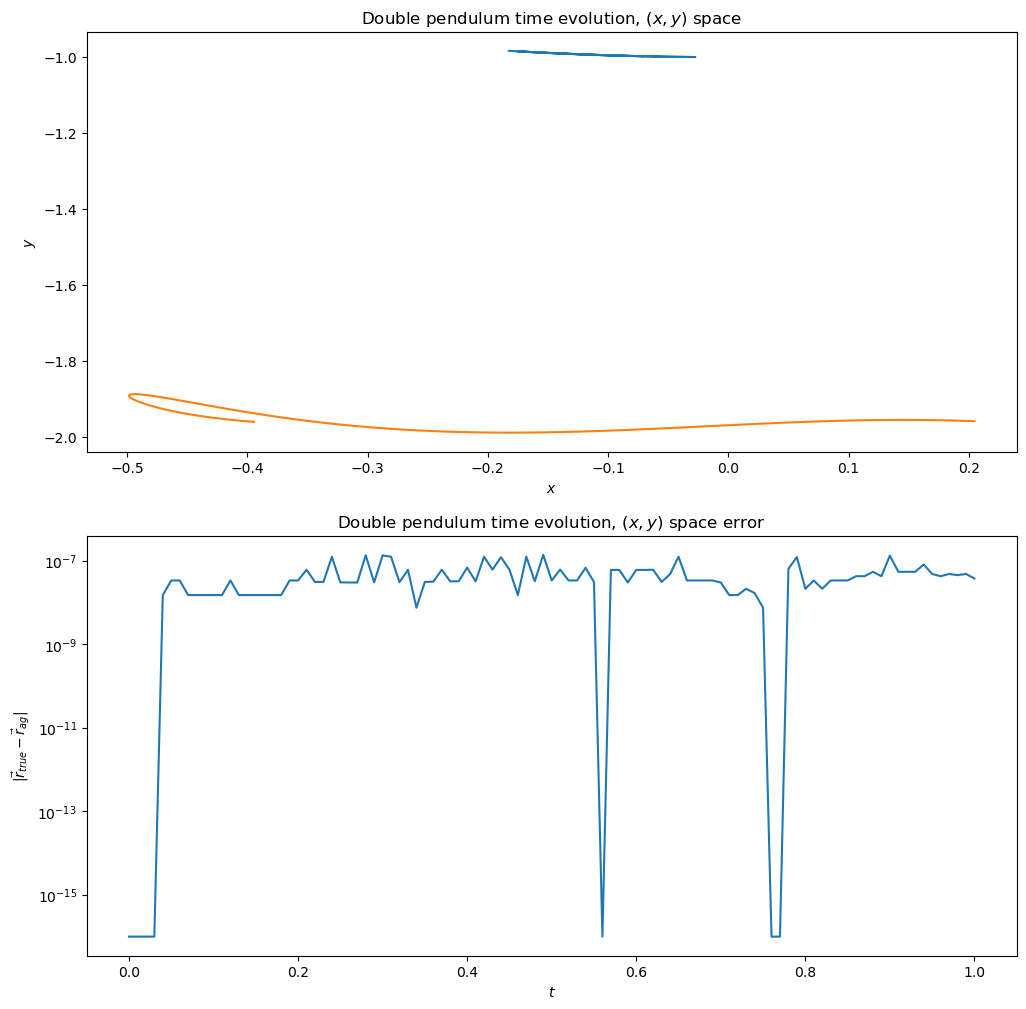

In [17]:
n_it = 100 #number of Euler steps
tmax = 1.0 #simulation time duration

random_initial_conditions = 1 #randomize t,tdot if == 1


if random_initial_conditions == 1: #if random initial conditions:
    t = 1*pi*(torch.rand(2) - 0.5)
    tdot = 1*pi*(torch.rand(2) - 0.5)
else: #if specified initial conditions
    t = tensor([0,0],dtype=torch.float) 
    tdot = tensor([1.5,-.5],dtype=torch.float)

ttrue = clone(t) #clone out initial conditions for true tdd
tdottrue = clone(tdot)


h = tmax/n_it #calculate timestep

#initialize storage arrays
t_arr = torch.zeros([n_it+1,2]) 
tdot_arr = torch.zeros([n_it+1,2])
ttrue_arr = torch.zeros([n_it+1,2])
tdottrue_arr = torch.zeros([n_it+1,2])

iter_arr = torch.arange(0,n_it+1) #index array, for plotting

#copy initial conditions to storage array
t_arr[0,:] = t
tdot_arr[0,:] = tdot
ttrue_arr[0,:] = ttrue
tdottrue_arr[0,:] = tdottrue

#######################
# main calculation loop
for i in tqdm.trange(1,n_it+1): #iterate Euler steps
    #autograd Euler step
    t, tdot = Euler_step(t,tdot,h,m1,m2,l1,l2) 
    t_arr[i,:] = t.data #store new positions/velocities
    tdot_arr[i,:] = tdot.data

    #true tdd Euler step
    ttrue, tdottrue = Euler_step_true(ttrue,tdottrue,h,m1,m2,l1,l2)
    ttrue_arr[i,:] = ttrue.data#store new positions/velocities
    tdottrue_arr[i,:] = tdottrue.data



####################################################
# post-processing, convert angles to (x,y) positions

#initialize storage arrays
r1 = torch.zeros([n_it+1,2]) #AG
r2 = torch.zeros([n_it+1,2])
r1t = torch.zeros([n_it+1,2]) #true
r2t = torch.zeros([n_it+1,2])

#store initial conditions in storage arrays
r1[0,0]  = l1*sin(t_arr[0,0]) #AG
r1[0,1] = -1*l1*cos(t_arr[0,0])
r2[0,0] = r1[0,0]  + l2*sin(t_arr[0,1])
r2[0,1] = r1[0,1]  + -1*l2*cos(t_arr[0,1])

r1t[0,0]  = l1*sin(ttrue_arr[0,0]) #true
r1t[0,1] = -1*l1*cos(ttrue_arr[0,0])
r2t[0,0] = r1t[0,0]  + l2*sin(ttrue_arr[0,1])
r2t[0,1] = r1t[0,1]  + -1*l2*cos(ttrue_arr[0,1])

#calculate (x,y) positions
for i in tqdm.trange(1,n_it+1): #iterate over timesteps
    r1[i,0]  = l1*sin(t_arr[i,0]) #AG
    r1[i,1] = -1*l1*cos(t_arr[i,0])
    r2[i,0] = r1[i,0]  + l2*sin(t_arr[i,1])
    r2[i,1] = r1[i,1]  + -1*l2*cos(t_arr[i,1])
    r1t[i,0]  = l1*sin(ttrue_arr[i,0]) #true
    r1t[i,1] = -1*l1*cos(ttrue_arr[i,0])
    r2t[i,0] = r1[i,0]  + l2*sin(ttrue_arr[i,1])
    r2t[i,1] = r1[i,1]  + -1*l2*cos(ttrue_arr[i,1])

##########
# plotting angles

fig1, axst = plt.subplots(2,1,figsize=(12,12)) #create subplots array

#plot angles
axst[0].plot(t_arr[:,0], t_arr[:,1],color='blue',label='autograd') #autograd angles
axst[0].plot(ttrue_arr[:,0], ttrue_arr[:,1],color='orange',label='true') #true angles
axst[0].set_xlabel(r'$\theta_1$') #plot formatting
axst[0].set_ylabel(r'$\theta_2$')
axst[0].set_title('Double pendulum time evolution')
axst[0].legend()

#plot L^2 error
axst[1].plot( h*iter_arr, sqrt((t_arr[:,0]-ttrue_arr[:,0])**2 +  (t_arr[:,1]-ttrue_arr[:,1])**2) + 1e-16) #plot error
axst[1].set_xlabel(r'$t$') #plot formatting
axst[1].set_ylabel(r'$|\theta_{true}-\theta|$')
axst[1].set_yscale('log')
axst[1].set_title('Double pendulum time evolution autograd error')

plt.show()

#################################
# plot (x,y) positions and errors



fig, axs = plt.subplots(2,1,figsize=(12,12)) #create subplots array

#plot positions
axs[0].plot(r1[:,0], r1[:,1]) #plot pendulum 1 position
axs[0].plot(r2[:,0], r2[:,1]) #plot pendulum 2 position
axs[0].set_xlabel(r'$x$') #plot formatting
axs[0].set_ylabel(r'$y$')
axs[0].set_title(r'Double pendulum time evolution, $(x,y)$ space')

#plot error
axs[1].plot(h*iter_arr, sqrt( (r1[:,0]-r1t[:,0])**2 + (r2[:,0]-r2t[:,0])**2 + (r1[:,1]-r1t[:,1])**2 + (r2[:,1]-r2t[:,1])**2 ) + 1e-16) #plot error
axs[1].set_xlabel(r'$t$') #plot formatting
axs[1].set_ylabel(r'$|\vec{r}_{true}-\vec{r}_{ag}|$')
axs[1].set_yscale('log')
axs[1].set_title(r'Double pendulum time evolution, $(x,y)$ space error')


plt.show()



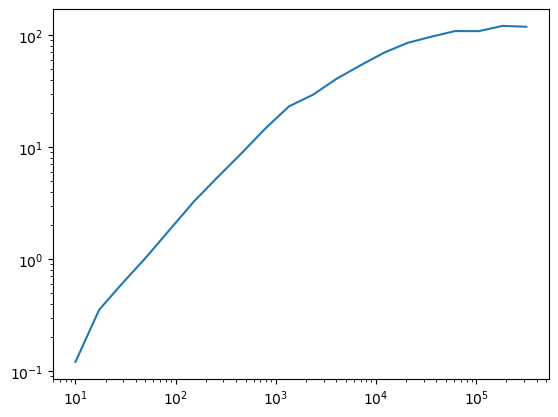

In [12]:
nsample_powers = torch.linspace(1,5.5,20)
nsample_arr = 10**nsample_powers
arr_s = nsample_arr.size()[0]
speedup_ratios = torch.zeros(arr_s)

nrep = 3

for k in range(arr_s):
    nsample = int(nsample_arr[k])
    
    v_times = torch.zeros(nrep)
    f_times = torch.zeros(nrep)
    
    for i in range(nrep):
        T = torch.rand([2,nsample])
        TDOT = torch.rand([2,nsample])
    
        t1v = time.time()
        qdd_v = QDDv(T,TDOT,m1,m2,l1,l2).mT
        v_times[i] = time.time() - t1v
        
        
        t1f = time.time()
        qdd_t = torch.zeros([2,nsample])
        for j in range(nsample):
            qdd_t[:,j] = QDD_true(T[:,j], TDOT[:,j], m1,m2,l1,l2)
        f_times[i] = time.time() - t1f
    speedup_ratios[k] = min(f_times)/min(v_times)
    
    #print(f"vtime: mean={mean(v_times):.2e}, stdev={std(v_times):.2e}")
    #print(f"ftime: mean={mean(f_times):.2e}, stdev={std(f_times):.2e}")
    #print(f"speedup ratio = {mean(f_times/v_times):.2f}")

plt.plot(nsample_arr,speedup_ratios)
plt.xscale('log')
plt.yscale('log')

plt.show()